In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from dataclasses import dataclass

/tmp/ipykernel_7811/3723902561.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [40]:
# Load the data
R = 800 # 800, 850, 1000, 1100, 1200
df1 = pd.read_csv(f'./cutting/r{R}.csv', header=None)
df1.columns = ["width", "height", "value"]

df2 = df1.copy()
df2["width"], df2["height"] = df2["height"], df2["width"]

data = pd.concat([df1, df2], ignore_index=True).reset_index(drop=True)

In [41]:
def calculate_bouding_angles(data, R):
    d_max = data["height"].max()
    max_theta = np.arcsin(d_max / (2 * R))
    return ((np.pi / 2) + max_theta, np.pi - max_theta)

alfa_min, alfa_max = calculate_bouding_angles(data, R)

def project_onto_circle(alfa, R):
    x = R * np.cos(alfa)
    y = R * np.sin(alfa)
    return x, y

In [42]:
class Rectangle():
    def __init__(self, x, y, type_id):
        self.width = data.loc[type_id, "width"]
        self.height = data.loc[type_id, "height"]
        self.value = data.loc[type_id, "value"]

        self.vertices = np.array([
            [x, y],
            [x + self.width, y],
            [x, y - self.height],
            [x + self.width, y - self.height]
        ])


    def fits_in_circle(self, R):
        v = np.linalg.norm(self.vertices, 2, axis=1) <= R
        return np.all(v)

    def __repr__(self):
        return f"Rectangle({self.width}, {self.height}, {self.value})"

In [43]:
from __future__ import annotations


@dataclass
class Genom:
    alfa: float
    types: list

    def guassian_mutation(self, sigma=0.1):
        """Uses gaussian mutation to mutate the alfa value of the genom."""
        noise = np.random.normal(0, sigma)
        alfa = np.clip(self.alfa + noise, alfa_min, alfa_max)
        return Genom(alfa, self.types)

    def change_type_mutation(self):
        """Changes the type of a random rectangle in the genom."""
        types = self.types.copy()
        idx = np.random.randint(len(types))
        types[idx] = np.random.randint(len(data))
        return Genom(self.alfa, types)

    def add_type_mutation(self):
        """Adds a random rectangle to the genom."""
        types = self.types.copy()
        types.append(np.random.randint(len(data)))
        return Genom(self.alfa, types)


@dataclass
class Individual:
    genom: Genom
    rectangles: list[Rectangle]

    @staticmethod
    def from_genom(genom: Genom):
        rectangles = []
        x, y = project_onto_circle(genom.alfa, R)
        for i, type_id in enumerate(genom.types):
            added = False

            rect = Rectangle(x, y, type_id)

            if y < 0 and R > np.abs(y - rect.height):
                x = -np.sqrt(R**2 - (y - rect.height)**2)
                rect = Rectangle(x, y, type_id)


            while rect.fits_in_circle(R):
                rectangles.append(rect)
                added = True

                x += rect.width
                rect = Rectangle(x, y, type_id)

            y -= rect.height

            if not added:
                genom.types = genom.types[:i]
                break


        return Individual(genom, rectangles)

    def fitness(self):
        return sum([rect.value for rect in self.rectangles])

    def plot(self):
        fig, ax = plt.subplots()
        
        circle = plt.Circle((0, 0), R, color='red', fill=False)
        ax.add_artist(circle)

        for rect in self.rectangles:
            ax.add_patch(plt.Rectangle(rect.vertices[2], rect.width, rect.height, edgecolor='blue', facecolor='none'))

        ax.set_xlim(-R, R)
        ax.set_ylim(-R, R)
        ax.set_aspect('equal', adjustable='datalim')
        return fig, ax

In [44]:
def get_parents(population: list[Individual], crossover_p: float = 0.7) -> tuple[list[Individual], list[Individual]]:
    """
    Split the population into two groups of parents
    """
    prob_vector = np.random.random(len(population))
    reproductive_population = [
        population[i] for i in range(len(population)) if prob_vector[i] < crossover_p
    ]
    idx = np.arange(len(reproductive_population))
    np.random.shuffle(idx)
    reproductive_population2 = [
        reproductive_population[i] for i in idx
    ]
    split_idx = len(reproductive_population2) // 2
    return reproductive_population2[:split_idx], reproductive_population2[split_idx:(2*split_idx)]

In [45]:
def mutate(individual: Individual, mutation_p: float = 0.3) -> Individual:
    """
    Mutate the individual with probability mutation_p
    """
    if np.random.random() < mutation_p:
        mutation = np.random.choice(
            [Genom.guassian_mutation, Genom.change_type_mutation, Genom.add_type_mutation],
            p=[0.2, 0.3, 0.5]
        )
        genom = mutation(individual.genom)
        return Individual.from_genom(genom)
    return individual

In [46]:
def crossover(ind1: Individual, ind2: Individual) -> Individual:
    """Performs crossover between two individuals."""
    genom1, genom2 = ind1.genom, ind2.genom
    alfa = genom1.alfa
    genom = Genom(alfa, genom1.types + genom2.types)
    ind = Individual.from_genom(genom)
    return ind

In [47]:
def elitism_selection(population: list[Individual], target_n: int, percentage: float = 0.15) -> list[Individual]:
    """Selects the n best individuals from the population."""
    n = int(len(population) * percentage)
    sorted_population = sorted(population, key=lambda x: x.fitness(), reverse=True)

    population = sorted_population[:n]
    left_over_population = sorted_population[n:]
    while len(population) < target_n:
        probs = np.array([ind.fitness() for ind in left_over_population])
        probs = probs / probs.sum()
        idx = np.random.choice(len(left_over_population), p=probs)
        ind = left_over_population.pop(idx)
        population.append(ind)

    return population

In [48]:
def random_individual() -> Individual:
    alfa = np.random.uniform(alfa_min, alfa_max)
    types = [np.random.randint(len(data))]
    return Individual.from_genom(Genom(alfa, types))

In [49]:
from tqdm.auto import tqdm

In [50]:
POPULATION_SIZE = 20
population = [random_individual() for _ in range(POPULATION_SIZE)]

N_GENERATIONS = 1000
for _ in tqdm(range(N_GENERATIONS)):

    parents1, parents2 = get_parents(population)

    children = []
    for p1, p2 in zip(parents1, parents2):
        child = crossover(p1, p2)
        child = mutate(child)
        children.append(child)
    
    population = elitism_selection(population + children, POPULATION_SIZE)

    best_individual = max(population, key=lambda x: x.fitness())
    best_fitness = best_individual.fitness()

  0%|          | 0/1000 [00:00<?, ?it/s]

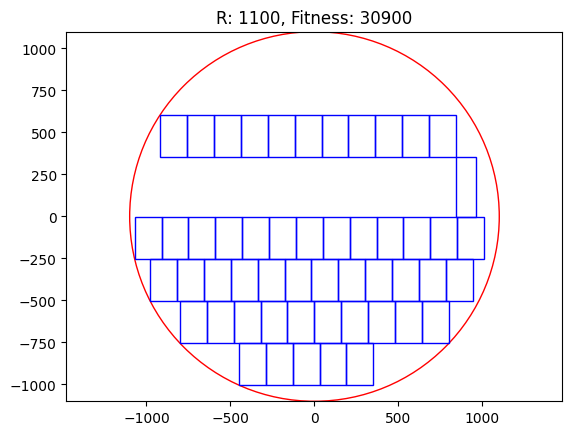

In [39]:
fig, ax = best_individual.plot()
plt.title(f"R: {R}, Fitness: {best_fitness}")
plt.show()
